In [1]:
import numpy as np
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import seaborn as sns
import matplotlib.pyplot as plt

In [140]:
grocery_df= pd.read_csv(r"/Users/iqrabismi/Desktop/Groceries data.csv")

In [141]:
grocery_df.head()

,Member_number,Date,itemDescription,year,month,day,day_of_week
0,1808,2015-07-21,tropical fruit,2015,7,21,1
1,2552,2015-05-01,whole milk,2015,5,1,4
2,2300,2015-09-19,pip fruit,2015,9,19,5
3,1187,2015-12-12,other vegetables,2015,12,12,5
4,3037,2015-01-02,whole milk,2015,1,2,4


## EDA

In [142]:
len(grocery_df)

38765

In [143]:
grocery_df.isna().sum()

Member_number      0
Date               0
itemDescription    0
year               0
month              0
day                0
day_of_week        0
dtype: int64

In [144]:
len(grocery_df[grocery_df.duplicated(keep='first')==True])

759

In [145]:
grocery_df.drop_duplicates(inplace=True)# Dropping the duplicates

In [146]:
grocery_df.dtypes

Member_number       int64
Date               object
itemDescription    object
year                int64
month               int64
day                 int64
day_of_week         int64
dtype: object

#### Checking the number of Items 

In [147]:
grocery_df['itemDescription'].value_counts(ascending=False).reset_index()
## Total number of 167 unique items

,index,itemDescription
0,whole milk,2363
1,other vegetables,1827
2,rolls/buns,1646
3,soda,1453
4,yogurt,1285
...,...,...
162,rubbing alcohol,5
163,bags,4
164,baby cosmetics,3
165,kitchen utensil,1


In [148]:
#### Number of Items bought wrt Year

date_df= grocery_df.groupby('Date')['itemDescription'].count().reset_index()


Text(0, 0.5, 'Number of Items Sold')

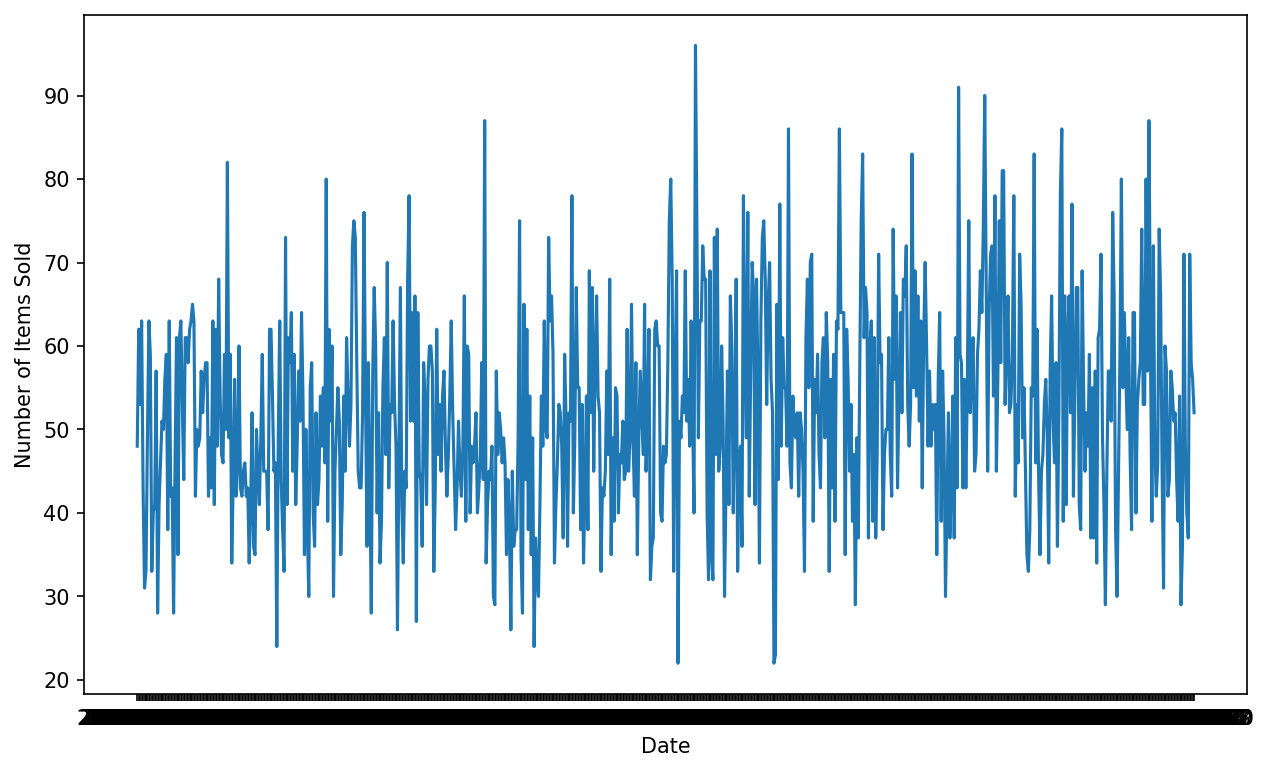

In [149]:
plt.figure(figsize=(10,6), dpi=150)
sns.lineplot(data= date_df, x='Date', y='itemDescription')
plt.xlabel('Date')
plt.ylabel('Number of Items Sold')

#### Day on which Max Number of Items were sold 

In [150]:
grocery_df.groupby('Date')['itemDescription'].count().idxmax()

'2015-01-21'

#### Day on which least number of items were sold

In [151]:
grocery_df.groupby('Date')['itemDescription'].count().idxmin()

'2015-01-09'

#### Top five most sold items

<Figure size 750x450 with 0 Axes>

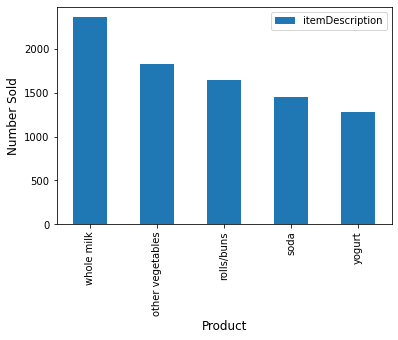

In [154]:
plt.figure(figsize=(5,3), dpi=150)
grocery_df.itemDescription.value_counts(ascending=False).reset_index().head(5).plot(kind='bar', x='index')
plt.xlabel('Product', size= 12)
plt.ylabel('Number Sold', size= 12)
plt.show()

## Data Transformation to implement Apriori and Association Algorithm

#### Number of Items bought by user in one transaction 

In [153]:
grocery_df[(grocery_df.Member_number==1808) & (grocery_df.Date== '2015-07-21')]

,Member_number,Date,itemDescription,year,month,day,day_of_week
0,1808,2015-07-21,tropical fruit,2015,7,21,1
16149,1808,2015-07-21,rolls/buns,2015,7,21,1
36088,1808,2015-07-21,candy,2015,7,21,1


### Creating an empty list transactions

In [161]:
member = grocery_df.Member_number.values # extracting unique members

In [162]:
dates = grocery_df.Date.values # extracting Dates

In [167]:
transactions = [list(grocery_df[(grocery_df['Member_number'] == i[0]) & (grocery_df['Date'] == i[1])].itemDescription) for i in zip(member,dates)]

In [168]:
transactions[0]

['tropical fruit', 'rolls/buns', 'candy']

In [169]:
print(len(transactions))

38006


### Creating Rules for Single Antecendent and Consequent

In [170]:
from itertools import permutations

In [172]:
flattenlist= [i for row in transactions for  i in row  ]

In [174]:
flattenlist= list(set(flattenlist))

In [175]:
rules = list(permutations(flattenlist,2))

In [177]:
rules[0], len(rules)

(('fruit/vegetable juice', 'ham'), 27722)

### Finding the Most Common Combination

In [187]:
from collections import Counter

In [191]:
newlist= []
for i in transactions:
    newlist.append(tuple(i))

In [192]:
c= Counter(newlist)

In [194]:
c.most_common(1)

[(('other vegetables', 'whole milk'), 98)]

### Encoding the data using TransactionEncoder

In [196]:
from mlxtend.preprocessing import TransactionEncoder

In [197]:
encoder = TransactionEncoder().fit(transactions)

In [198]:
onehot = encoder.transform(transactions)

In [199]:
onehot = pd.DataFrame(onehot, columns = encoder.columns_)
onehot.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,True,False,False


In [200]:
len(onehot)

38006

### Computing Support for Single Items

In [201]:
print(onehot.mean())

Instant food products    0.004499
UHT-milk                 0.024575
abrasive cleaner         0.001921
artif. sweetener         0.002947
baby cosmetics           0.000316
                           ...   
white bread              0.029022
white wine               0.013840
whole milk               0.181445
yogurt                   0.100931
zwieback                 0.004868
Length: 167, dtype: float64


### Computing Support, Confidence, Zhang Metric and Lift for other vegetables <- Whole Milk

#### Support: Support is an indication of how frequently the item set appears in the data set.

supp(X⇒Y)=|X∪Y|n where n is number of transactions

In [202]:
onehot['other vegetables & whole milk'] = np.logical_and(onehot['other vegetables'],onehot['whole milk'])

In [203]:
print(onehot.mean())

Instant food products            0.004499
UHT-milk                         0.024575
abrasive cleaner                 0.001921
artif. sweetener                 0.002947
baby cosmetics                   0.000316
                                   ...   
white wine                       0.013840
whole milk                       0.181445
yogurt                           0.100931
zwieback                         0.004868
other vegetables & whole milk    0.021944
Length: 168, dtype: float64


#### Confidence: For a rule X⇒Y, confidence shows the percentage in which Y is bought with X. It’s an indication of how often the rule has been found to be true.

conf(X⇒Y)=supp(X∪Y)supp(X)

In [204]:
support_milk= onehot['whole milk'].mean()
support_vegetable= onehot['other vegetables & whole milk'].mean()
support_vegandmilk= np.logical_and(onehot['other vegetables'],onehot['whole milk']).mean()

In [215]:
confidence= support_vegandmilk/support_vegetable

In [213]:
print("Confidence: ", confidence)

Confidence:  1.0


#### Lift: It is metric for evaluating the relationship between items.
Numerator: Proportion of transactions that contain X and Y.
Denominator: Proportion if X and Y assigned randomly and independently.
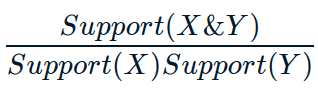

In [218]:
lift = support_vegandmilk/(support_vegetable* support_milk)

In [219]:
print("Lift: ", lift)

Lift:  5.511310904872389


#### Leverage: It lies in the range -1 to +1 and is easy to interpret
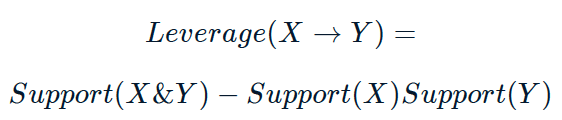

In [220]:
Leverage= support_vegandmilk - (support_vegetable* support_milk)

In [221]:
print("Leverage: ", Leverage)

Leverage:  0.01796229123860991


#### Zhang Metric: It measures association as well as dissociation. Value of +1 indicates perfect association. Value of -1 indicates perfect dissociation. 
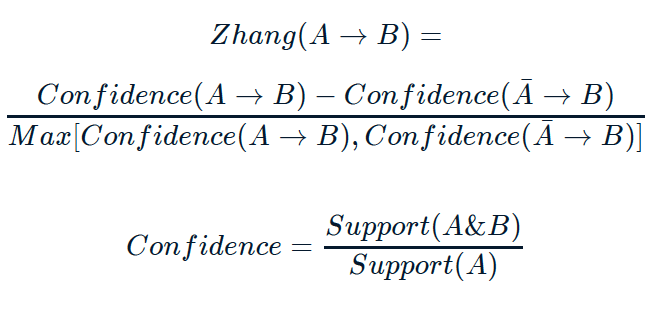

In [222]:
support_milk= onehot['whole milk'].mean()
support_vegetable= onehot['other vegetables & whole milk'].mean()
support_vegandmilk= np.logical_and(onehot['other vegetables'],onehot['whole milk']).mean()

In [223]:
num = support_vegandmilk - support_milk*support_vegetable

In [224]:
denom = max(support_vegandmilk*(1-support_vegetable), support_vegetable*(support_milk-support_vegandmilk))

In [225]:
zhang = num / denom
print("Zhang Metric" ,zhang) # Value is positive, so positive association

Zhang Metric 0.8369202625632196


### Implementing the Apriori Algorithm: Apriori algorithm prunes itemsets on basis of min support, rather than association rules.

1. Apriori prunes itemsets.
2. Applies minimum support threshold.
3. Modiified version can prune by number of items.
4. Doesn't tell us about association rules.
5. Difficult to compute for higher number of items

In [384]:
frequent_itemsets = apriori(onehot, min_support = 0.01, max_len = 3, use_colnames = True)

In [385]:
print(len(frequent_itemsets))

92


In [386]:
frequent_itemsets.head()

,support,itemsets
0,0.024575,(UHT-milk)
1,0.039599,(beef)
2,0.024917,(berries)
3,0.019365,(beverages)
4,0.054860,(bottled beer)


### Implementing Association Rules: association_rules() takes frequent items, metric, and threshold.

In [387]:
from mlxtend.frequent_patterns import apriori, association_rules

In [408]:
frequent_itemsets = apriori(onehot, use_colnames=True, min_support=0.01, max_len = 2)

#### Pruning using support

In [409]:
rules = association_rules(frequent_itemsets,metric = "support",min_threshold = 0.0)

In [410]:
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(whole milk),(bottled beer),0.181445,0.054860,0.010472,0.057715,1.052039,0.000518,1.003030
1,(bottled beer),(whole milk),0.054860,0.181445,0.010472,0.190887,1.052039,0.000518,1.011670
2,(bottled water),(whole milk),0.069226,0.181445,0.010209,0.147472,0.812766,-0.002352,0.960151
3,(whole milk),(bottled water),0.181445,0.069226,0.010209,0.056265,0.812766,-0.002352,0.986266
4,(whole milk),(citrus fruit),0.181445,0.060911,0.011261,0.062065,1.018938,0.000209,1.001230


In [411]:
len(rules)

42

In [412]:
rules.consequents.unique()

array([frozenset({'bottled beer'}), frozenset({'whole milk'}),
       frozenset({'bottled water'}), frozenset({'citrus fruit'}),
       frozenset({'other vegetables'}), frozenset({'rolls/buns'}),
       frozenset({'sausage'}), frozenset({'soda'}), frozenset({'yogurt'}),
       frozenset({'other vegetables & whole milk'}),
       frozenset({'pastry'}), frozenset({'root vegetables'}),
       frozenset({'tropical fruit'})], dtype=object)

#### Computing Zhang's Rule to see disassociation

In [413]:
def zhangs_rule(rules):
    rule_support = rules['support'].copy()
    rule_ante = rules['antecedent support'].copy()
    rule_conseq = rules['consequent support'].copy()
    num = rule_support - (rule_ante * rule_conseq)
    denom = np.max((rule_support * (1 - rule_ante).values, 
                          rule_ante * (rule_conseq - rule_support).values), axis = 0)
    return num / denom

rules_zhangs_list = zhangs_rule(rules)
rules = rules.assign(zhang = rules_zhangs_list)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhang
0,(whole milk),(bottled beer),0.181445,0.054860,0.010472,0.057715,1.052039,0.000518,1.003030,0.060430
1,(bottled beer),(whole milk),0.054860,0.181445,0.010472,0.190887,1.052039,0.000518,1.011670,0.052336
2,(bottled water),(whole milk),0.069226,0.181445,0.010209,0.147472,0.812766,-0.002352,0.960151,-0.198396
3,(whole milk),(bottled water),0.181445,0.069226,0.010209,0.056265,0.812766,-0.002352,0.986266,-0.219622
4,(whole milk),(citrus fruit),0.181445,0.060911,0.011261,0.062065,1.018938,0.000209,1.001230,0.022706


#### filtering the value with zhang rules <0 to see disassociation

In [414]:
rules[rules.zhang<=0]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhang
2,(bottled water),(whole milk),0.069226,0.181445,0.010209,0.147472,0.812766,-0.002352,0.960151,-0.198396
3,(whole milk),(bottled water),0.181445,0.069226,0.010209,0.056265,0.812766,-0.002352,0.986266,-0.219622
6,(rolls/buns),(other vegetables),0.126822,0.136531,0.015576,0.122822,0.899587,-0.001739,0.984371,-0.113344
7,(other vegetables),(rolls/buns),0.136531,0.126822,0.015576,0.114087,0.899587,-0.001739,0.985625,-0.114473
10,(other vegetables),(soda),0.136531,0.111482,0.013945,0.102139,0.916191,-0.001276,0.989594,-0.095792
11,(soda),(other vegetables),0.111482,0.136531,0.013945,0.125089,0.916191,-0.001276,0.986921,-0.093343
12,(whole milk),(other vegetables),0.181445,0.136531,0.021944,0.120940,0.885803,-0.002829,0.982264,-0.136066
13,(other vegetables),(whole milk),0.136531,0.181445,0.021944,0.160725,0.885803,-0.002829,0.975312,-0.129908
14,(other vegetables),(yogurt),0.136531,0.100931,0.012288,0.089998,0.891675,-0.001493,0.987985,-0.123340
15,(yogurt),(other vegetables),0.100931,0.136531,0.012288,0.121741,0.891675,-0.001493,0.983160,-0.119038


#### filtering the value with zhang rules >0  to see positive association 

In [415]:
rules[rules.zhang>0].sort_values('zhang', ascending=False) 

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhang
41,(whole milk),(other vegetables & whole milk),0.181445,0.021944,0.021944,0.120940,5.511311,0.017962,1.112615,1.000000
17,(other vegetables),(other vegetables & whole milk),0.136531,0.021944,0.021944,0.160725,7.324340,0.018948,1.165358,1.000000
16,(other vegetables & whole milk),(other vegetables),0.021944,0.136531,0.021944,1.000000,7.324340,0.018948,inf,0.882842
40,(other vegetables & whole milk),(whole milk),0.021944,0.181445,0.021944,1.000000,5.511311,0.017962,inf,0.836920
33,(yogurt),(sausage),0.100931,0.074225,0.010051,0.099583,1.341633,0.002559,1.028162,0.283226
32,(sausage),(yogurt),0.074225,0.100931,0.010051,0.135413,1.341633,0.002559,1.039882,0.275056
29,(soda),(sausage),0.111482,0.074225,0.010051,0.090158,1.214658,0.001776,1.017512,0.198896
28,(sausage),(soda),0.074225,0.111482,0.010051,0.135413,1.214658,0.001776,1.027679,0.190892
31,(whole milk),(sausage),0.181445,0.074225,0.014998,0.082657,1.113593,0.001530,1.009191,0.124617
30,(sausage),(whole milk),0.074225,0.181445,0.014998,0.202056,1.113593,0.001530,1.025830,0.110185


#### Pruning using Leverage metric

In [293]:
rules = association_rules(frequent_itemsets,metric = "leverage", min_threshold = 0)

In [294]:
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(whole milk),(bottled beer),0.181445,0.054860,0.010472,0.057715,1.052039,0.000518,1.003030
1,(bottled beer),(whole milk),0.054860,0.181445,0.010472,0.190887,1.052039,0.000518,1.011670
2,(whole milk),(citrus fruit),0.181445,0.060911,0.011261,0.062065,1.018938,0.000209,1.001230
3,(citrus fruit),(whole milk),0.060911,0.181445,0.011261,0.184881,1.018938,0.000209,1.004216
4,(sausage),(other vegetables),0.074225,0.136531,0.010840,0.146048,1.069702,0.000706,1.011144


In [295]:
len(rules)

24

In [296]:
rules.consequents.unique()

array([frozenset({'bottled beer'}), frozenset({'whole milk'}),
       frozenset({'citrus fruit'}), frozenset({'other vegetables'}),
       frozenset({'sausage'}),
       frozenset({'other vegetables & whole milk'}), frozenset({'soda'}),
       frozenset({'yogurt'}),
       frozenset({'whole milk', 'other vegetables'}),
       frozenset({'other vegetables & whole milk', 'other vegetables'}),
       frozenset({'other vegetables & whole milk', 'whole milk'})],
      dtype=object)

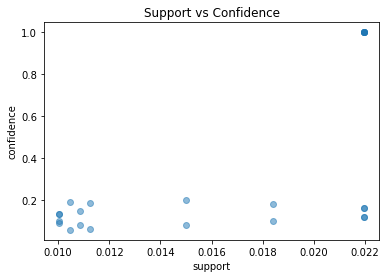

In [297]:
plt.scatter(rules['support'], rules['confidence'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('confidence')
plt.title('Support vs Confidence')
plt.show()

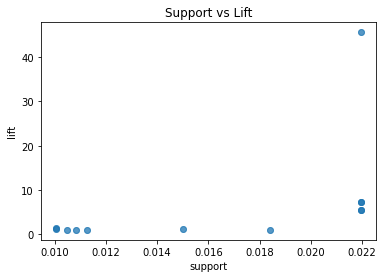

In [298]:
plt.scatter(rules['support'], rules['lift'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('lift')
plt.title('Support vs Lift')
plt.show()

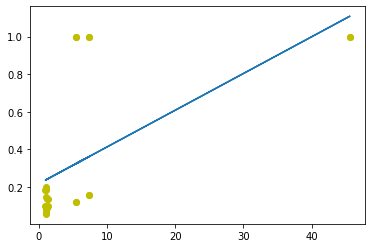

In [299]:
fit = np.polyfit(rules['lift'], rules['confidence'], 1)
fit_fn = np.poly1d(fit)
plt.plot(rules['lift'], rules['confidence'], 'yo', rules['lift'],fit_fn(rules['lift']))

### Multi Metric Filtering

#### Targeting consequent == whole milk

In [317]:
targeted_rules = rules[rules['consequents'] == {'whole milk'}].copy()

In [318]:
targeted_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1,(bottled beer),(whole milk),0.054860,0.181445,0.010472,0.190887,1.052039,0.000518,1.011670
3,(citrus fruit),(whole milk),0.060911,0.181445,0.011261,0.184881,1.018938,0.000209,1.004216
10,(sausage),(whole milk),0.074225,0.181445,0.014998,0.202056,1.113593,0.001530,1.025830
15,(yogurt),(whole milk),0.100931,0.181445,0.018392,0.182221,1.004277,0.000078,1.000949
16,(other vegetables & whole milk),(whole milk),0.021944,0.181445,0.021944,1.000000,5.511311,0.017962,inf
19,"(other vegetables & whole milk, other vegetables)",(whole milk),0.021944,0.181445,0.021944,1.000000,5.511311,0.017962,inf


In [321]:
filtered_rules = targeted_rules[(targeted_rules['antecedent support'] > 0.01) &
(targeted_rules['support'] > 0.009) &
(targeted_rules['confidence'] > 0.85) &
(targeted_rules['lift'] > 1.00)]

In [322]:
print(filtered_rules['antecedents'])

16                      (other vegetables & whole milk)
19    (other vegetables & whole milk, other vegetables)
Name: antecedents, dtype: object


### Visualising the rules

In [331]:
frequent_itemsets = apriori(onehot, min_support=0.01,use_colnames=True, max_len=2)

In [332]:
len(frequent_itemsets )

91

In [339]:
rules = association_rules(frequent_itemsets,metric = "support",min_threshold = 0.0)

In [336]:
len(rules)

42

In [342]:
# Convert antecedents and consequents into strings
rules['antecedents'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

In [344]:
print(rules[['antecedents','consequents']].head())

     antecedents    consequents
0     whole milk   bottled beer
1   bottled beer     whole milk
2  bottled water     whole milk
3     whole milk  bottled water
4     whole milk   citrus fruit


In [345]:
support_table = rules.pivot(index='consequents', columns='antecedents',values='support')

In [346]:
support_table.head()

antecedents,bottled beer,bottled water,citrus fruit,other vegetables,other vegetables & whole milk,pastry,rolls/buns,root vegetables,sausage,soda,tropical fruit,whole milk,yogurt
consequents,,,,,,,,,,,,,
bottled beer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010472,NaN
bottled water,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010209,NaN
citrus fruit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011261,NaN
other vegetables,NaN,NaN,NaN,NaN,0.021944,NaN,0.015576,NaN,0.01084,0.013945,NaN,0.021944,0.012288
other vegetables & whole milk,NaN,NaN,NaN,0.021944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.021944,NaN


In [348]:
import seaborn as sns

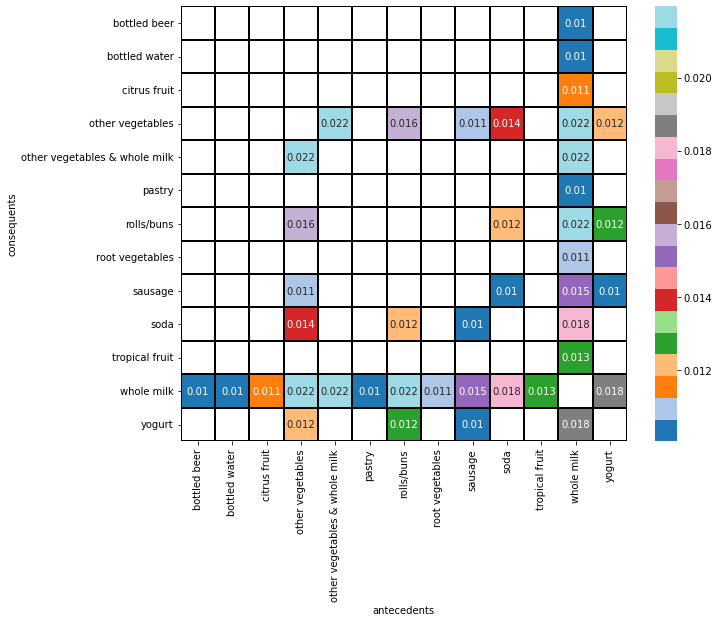

In [352]:
plt.figure(figsize=(10,8))
sns.heatmap(support_table, cmap= "tab20", annot=True, linewidths= 2, linecolor= 'black')
plt.show()

#### From heat map above, we can see following association:
1. other vegetable <-- whole milk
2. rolls/buns <-- whole milk 


<AxesSubplot:xlabel='antecedent support', ylabel='consequent support'>

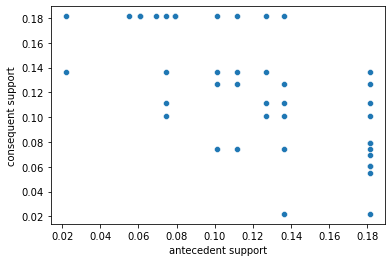

In [353]:
sns.scatterplot(x="antecedent support", y="consequent support", data=rules)

<AxesSubplot:xlabel='antecedent support', ylabel='consequent support'>

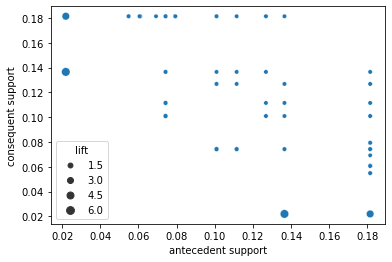

In [355]:
sns.scatterplot(x="antecedent support",y="consequent support",size="lift",data=rules)

#### scatter plot above, we can observe that no support exceeds value 0.18. 

### Parallel coordinate plots to observe Rules

In [425]:
frequent_itemsets = apriori(onehot, min_support=0.01,use_colnames=True, max_len=2)

In [426]:
rules = association_rules(frequent_itemsets,metric = 'lift', min_threshold = 1.00)

In [427]:
rules['antecedent'] = rules['antecedents'].apply(lambda antecedent: list(antecedent)[0])
rules['consequent'] = rules['consequents'].apply(lambda consequent: list(consequent)[0])
rules['rule'] = rules.index

In [428]:
coords = rules[['antecedent','consequent','rule']]
# Print example
print(coords.head(1))

   antecedent    consequent  rule
0  whole milk  bottled beer     0


In [429]:
from pandas.plotting import parallel_coordinates

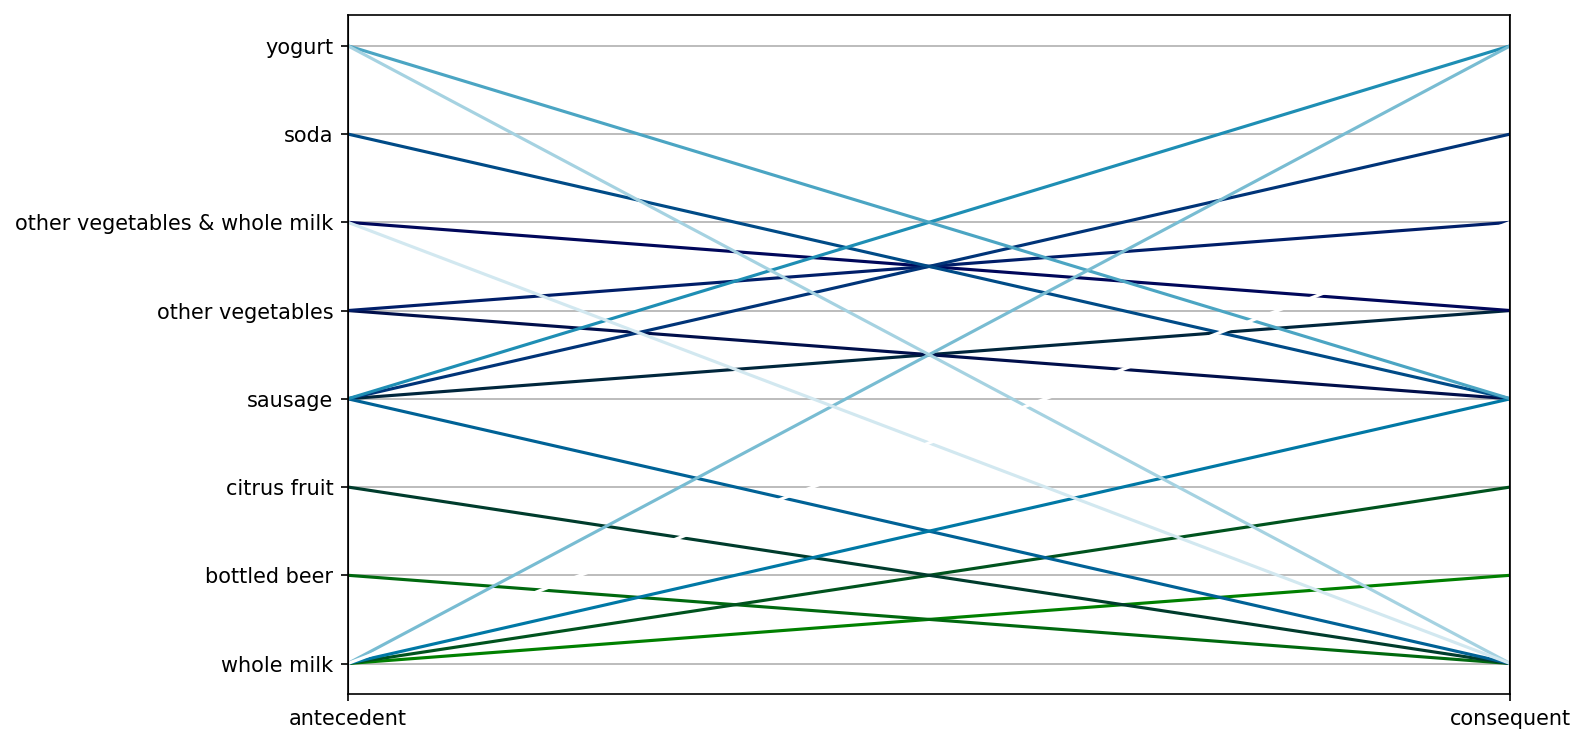

In [430]:
plt.figure(figsize= (10,6), dpi= 150)
ax= parallel_coordinates(coords, 'rule', colormap = 'ocean')
leg = plt.legend()
 
ax.get_legend().remove()
plt.show()

#### From the plot above, we can different associations of antencendent and consequent in which ligher shaded lines shows stronger association such as yogurt <- whole milk 

In [431]:
def zhangs_rule(rules):
    rule_support = rules['support'].copy()
    rule_ante = rules['antecedent support'].copy()
    rule_conseq = rules['consequent support'].copy()
    num = rule_support - (rule_ante * rule_conseq)
    denom = np.max((rule_support * (1 - rule_ante).values, 
                          rule_ante * (rule_conseq - rule_support).values), axis = 0)
    return num / denom

rules_zhangs_list = zhangs_rule(rules)
rules = rules.assign(zhang = rules_zhangs_list)


In [432]:
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent,consequent,rule,zhang
0,(whole milk),(bottled beer),0.181445,0.054860,0.010472,0.057715,1.052039,0.000518,1.003030,whole milk,bottled beer,0,0.060430
1,(bottled beer),(whole milk),0.054860,0.181445,0.010472,0.190887,1.052039,0.000518,1.011670,bottled beer,whole milk,1,0.052336
2,(whole milk),(citrus fruit),0.181445,0.060911,0.011261,0.062065,1.018938,0.000209,1.001230,whole milk,citrus fruit,2,0.022706
3,(citrus fruit),(whole milk),0.060911,0.181445,0.011261,0.184881,1.018938,0.000209,1.004216,citrus fruit,whole milk,3,0.019791
4,(sausage),(other vegetables),0.074225,0.136531,0.010840,0.146048,1.069702,0.000706,1.011144,sausage,other vegetables,4,0.070384


#### From this we can see whole milk is bought with beer and citrus fruits and sausages are bought with other vegetables